Whisper audio preprocessing process:
- We are given an array A representing the audio signal samples.
- The audio signal A is resampled at a sampling rate of 16000Hz.
- A stft is performed using a hann window of size 400(25ms) and hop length of 160(10ms).
- The stft results are squared
- The stft frequencies are converted to mel scale.
- We take the log of the results.

The discrete fourier transform(dft):
- To perform an stft(short-time fourier transform) on the signal we apply dft on 25ms segments.
- The dft converts the audio signal from the time domain to frequency domain.
- Essentially, it computes the magnitudes of the frequencies of pure sine/cosine waves that make up
  the original signal when added together.
- The conversion from time domain to frequency domain is motivated by the fact that human auditory
  system also performs something akin to dft known as frequency selectivity[1].
- The frequency representation also performs better in practice than raw audio[2]. Well, for some tasks atleast.
- When converting from time domain to signal domain, we first need to know what range of frequencies
  of pure tones that make up the original signal in order to calculate their magnitudes.
- The Nyquist–Shannon sampling theorem implies that our signal, which has is sampled at 16000Hz, cannot contain frequencies greater
  than 16000Hz/2 = 8000Hz. Thus the frequency range of our audio is 0Hz - 8000Hz.
- The key to finding the magnitudes of each of the frequency in the frequency range is by using
  cross-correlation.
- Cross-correlation is a function of two signals of the same length that calculates how close the two signals are.
- Given two signals f and g with each with N samples, it is given by $$\sum_{t=0}^{N-1}f(t)g(t)$$
- Intuitively, if the signals are positively correlated, we expect a large positive number. If they are negatively correlated
  we expect a large negative number. If they are not correlated we expect a number close to zero.
- Given a signal f, we can obtain a magnitude for a sinusoid with frequency k, using the following formula:
   $$F[k] = \frac{1}{N} \sum_{t=0}^{N-1}f(t)e^\frac{-i2\pi kt}{N}$$
- The above formula is a cross-correlation between the given signal and a sum of two pure signals, namely, sine and cosine.
  We use both sine and cosine to ensure that we capture the magnitude of the sinusoid with frequency k regardless of its phase.
- The formula can be expanded as follows:
  $$F[k] = \frac{1}{N} \sum_{t=0}^{N-1}f(t)[\cos(\frac{2\pi kt}{N}) + i\sin(\frac{2\pi kt}{N})]$$
- To simplify further, we can decompose the single sum into two sums, one with the cosine term and the other with the sine term as follows:
  $$F[k] = \frac{1}{N} \sum_{t=0}^{N-1}f(t)\cos(\frac{2\pi kt}{N}) + \frac{1}{N} \sum_{t=0}^{N-1}f(t)i\sin(\frac{2\pi kt}{N})$$
- To see why the above formula works, let's assume that we have a signal f made from two pure sinusoids, one with frequency f1
  and the other with frequency f2. We can represent f mathematically as:
  $$ f(t) = \cos(\frac{2\pi f_{1}t}{N}) + \cos(\frac{2\pi f_{2}t}{N}) $$
- Let's say, for instance, that we want to compute the magnitude of frequency f1. When we apply the first sum (real part) of the dft
  formula, we get:
    $$ F[f_{1}] = \frac{1}{N} \sum_{t=0}^{N-1}[\cos(\frac{2\pi f_{1}t}{N}) + \cos(\frac{2\pi f_{2}t}{N})]\cos(\frac{2\pi f_{1}t}{N}) $$
- After expanding and splitting the sum into two, we get:
$$ F[f_{1}] = \frac{1}{N} \sum_{t=0}^{N-1}\cos(\frac{2\pi f_{1}t}{N})\cos(\frac{2\pi f_{1}t}{N}) + \sum_{t=0}^{N-1}\cos(\frac{2\pi f_{1}t}{N})\cos(\frac{2\pi f_{2}t}{N}) $$
- The first sum represents the cross-correlation between the sinusoid with frequency f1 and itself, because it is present in
  the original signal.
- The second sum represents the cross-correlation between the sinusoid with frequency f1 and one with frequency f2. Because the   two signals are not correlated(because they have different frequencies) we expect the sum to be very close to zero.
- Thus when we add the two magnitudes, we are adding the correct magnitude plus very small number which has no effect on
  the result.
- Even when the original signal is made up of thousands of sinusoids, we still end up with the correct magnitude plus or
  minus very small perturbation.
  
References
- [1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4290461/
- [2] https://www.arxiv.org/abs/1811.10708v1

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def sin_signal(n, f, amplitude=1): 
    return amplitude * np.sin(np.linspace(0, 2*np.pi*f, n, endpoint=False))

def cos_signal(n, f, amplitude=1): 
    return amplitude * np.cos(np.linspace(0, 2*np.pi*f, n, endpoint=False))

def plot_spec(spec):
    plt.figure(figsize=(18, 6))
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.bar(np.arange(len(spec)), np.abs(spec))

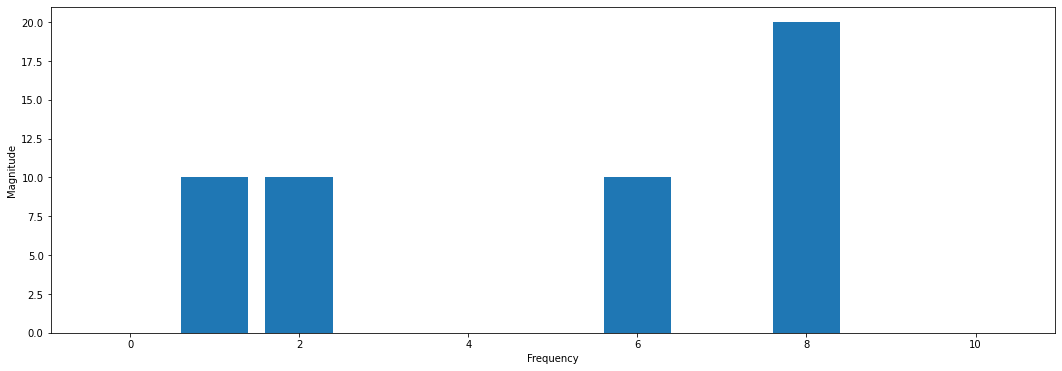

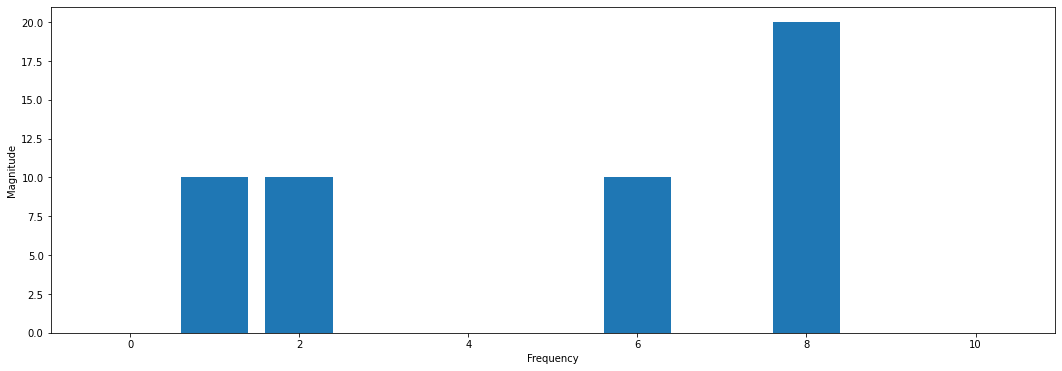

In [ ]:
# DFT (NAIVE) IMPLEMENTATION
def dft(signal, sample_rate, norm=None):
    N = len(signal)
    max_freq = sample_rate//2
    spectrogram = np.zeros(max_freq+1, dtype=np.complex128)
    for f in range(max_freq+1):
        real = np.cos((np.arange(N) * 2*np.pi*f) / N)
        imag = np.sin((np.arange(N) * 2*np.pi*f) / N) * -1j
        if norm == 'forward':
            # perform normalization as in the formula.
            corr = np.sum(signal * (real + imag)) / N
        else:
            # Used in practice because it allows for numerical stability especially when N is large.
            corr = np.sum(signal * (real + imag))
        spectrogram[f] = corr
    return spectrogram

# A signal composed of pure sine waves with freq 1, 2, 6 and a cosine wave with frequency 8.
composite_signal = sin_signal(20, 1) + sin_signal(20, 2) + sin_signal(20, 6) + cos_signal(20, 8, amplitude=2)
spec = dft(composite_signal, 20)
plot_spec(spec)
# For comparison
torch_spec = torch.fft.rfft(torch.tensor(composite_signal)).abs()
plot_spec(torch_spec)

Mel scale
- Human hearing range 20Hz - 20000Hz.
- The difference between 100Hz and 200Hz is clear but the difference between 1000Hz, 1100Hz is not noticeable.
- We need to find a scale such that the difference between perception of any two equidistant frequencies is the same.
- A formula to convert frequency in Hz to mel scale is given by: $$ m = \log_{10}(1 + \frac{f}{100}) $$
- The formula used for whisper is implemented by Librosa as: $ f / f_{step} $  for f <= 1000 while for higher
  frequencies, we have $$ (m_{b} + ln(\frac{f}{1000})/m_{step}) / f_{step} $$
  where $f_{step}=66.67, m_{b}=1000/f_{step}$  and $m_{step}=\ln(6.4)/27$